In [242]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Introduction

Не знаю, как оценивается работа, напишу, как было

Решение состоит из нескольких частей:

- Анализ данных
- Внесение коррекций в датасет
- Построение модели

## Data analysis

lets look at some features, see what correlations we could find

In [243]:
df_train = pd.read_csv('./input/train.csv')
df_test = pd.read_csv('./input/test.csv')

# train_ID = train['Id']
# test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

<AxesSubplot:>

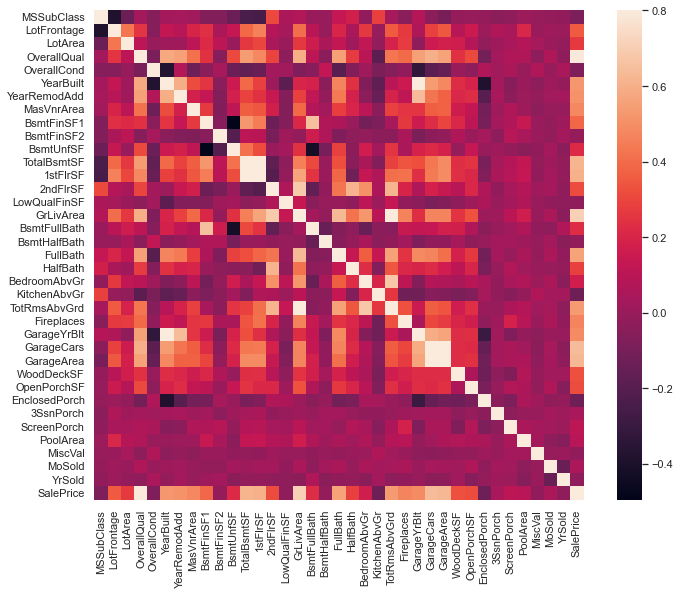

In [244]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

We can see that OveralllQual, TotalBsmtSF, 1stFlrSF, GrLivArea, GarageCars, GarageArea are highly correlated with SalePrice

Let's use smaller heatmap to see possible correlated variables:

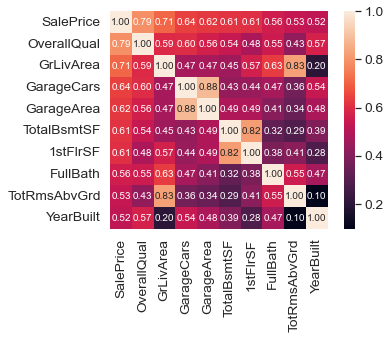

In [245]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

From there we can see that there is a correlation between GrLivArea and TotRmsAbvGrd, GarageCars and GarageArea, TotalBsmtSF and 1stFlrSF.

So lets drop less correlated features, leaving GrLivArea, GarageCars, TotalBsmtSF

There is one more beautiful plot we can use to visualize data:

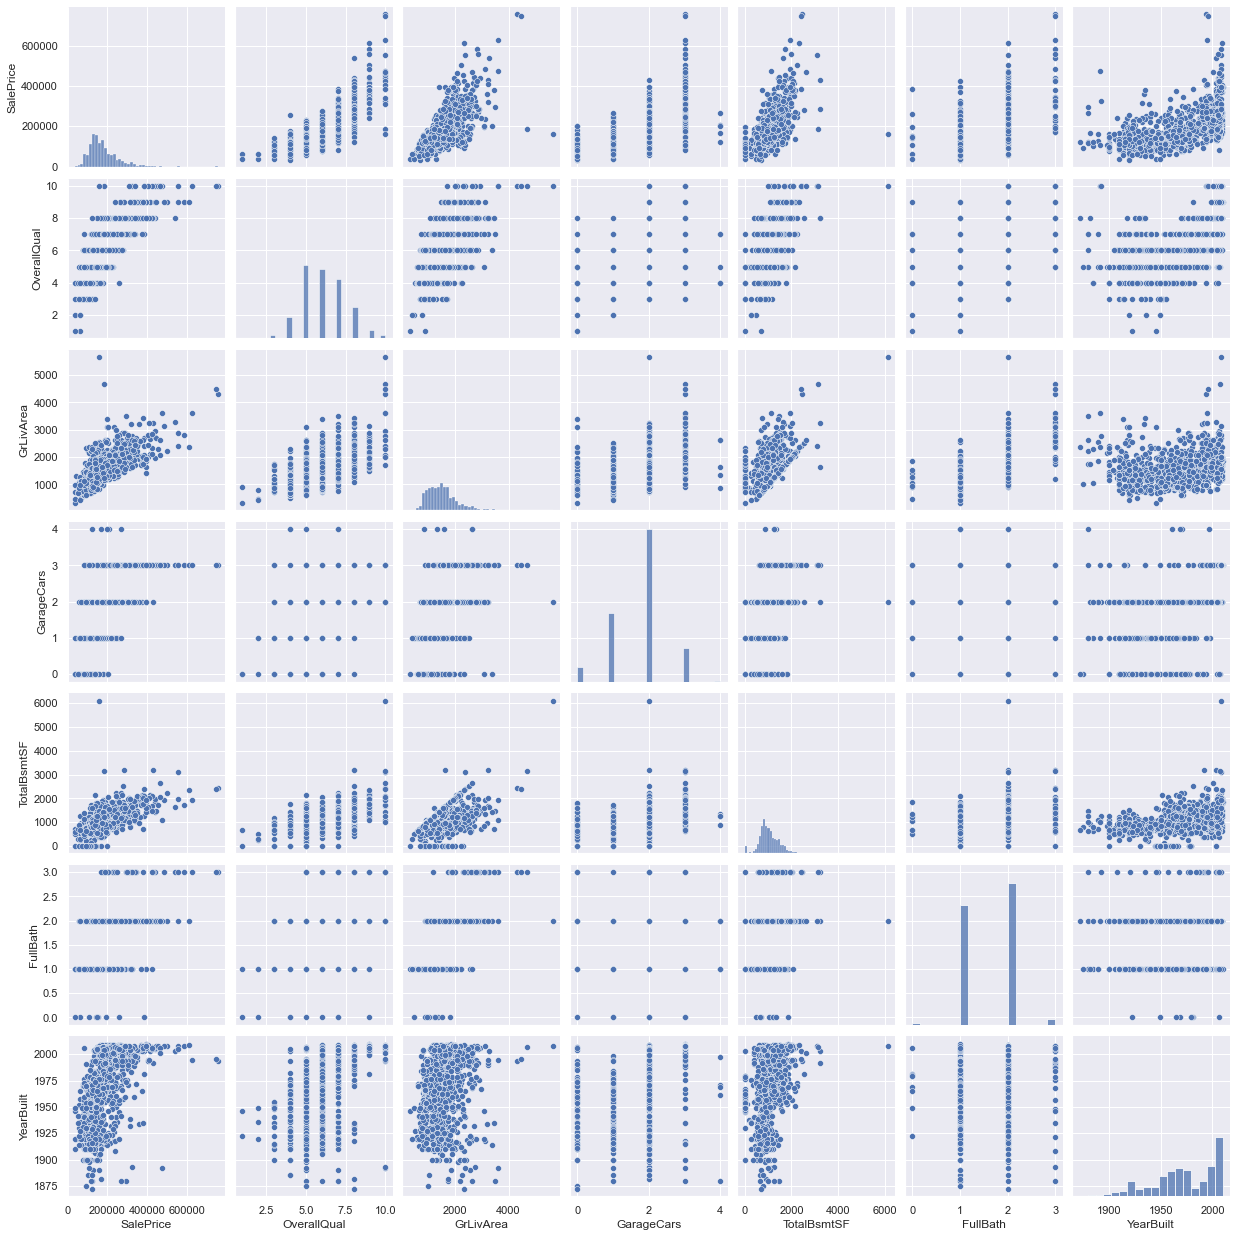

In [246]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(df_train[cols], height = 2.5)
plt.show();

## Dealing with missing data

lets look at NaNs in dataset

In [247]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageYrBlt      81  0.055479
GarageCond       81  0.055479
GarageType       81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtExposure     38  0.026027
BsmtFinType2     38  0.026027
BsmtCond         37  0.025342
BsmtQual         37  0.025342
BsmtFinType1     37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685
MSSubClass        0  0.000000

First of all, lets cut out all of the features above, exept for "Electrical": we can just delete observation with missing data and move on

In [248]:
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index, 1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)

# is there any data missing?
df_train.isnull().sum().max()

0

## Figuring out outliers

this smart writeup on this issue told me that we can find irregularities easily if we standardize data first:

In [249]:
saleprice_scaled = StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis])
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


## Lets miss this step for now and see model performance

In [250]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [251]:
y_train = df_train.SalePrice.values
print(y_train.shape)

ntrain = df_train.shape[0]
ntest = df_test.shape[0]

all_data = pd.concat((df_train, df_test), axis=0).reset_index(drop=True)
all_data.drop(["SalePrice"], axis=1, inplace=True)

all_data = all_data.dropna(axis=1)
print("all_data size is : {}".format(all_data.shape))
all_data.head()

(1459,)
all_data size is : (2918, 46)


MSSubClass  LotArea Street LotShape LandContour LotConfig LandSlope  \
0          60     8450   Pave      Reg         Lvl    Inside       Gtl   
1          20     9600   Pave      Reg         Lvl       FR2       Gtl   
2          60    11250   Pave      IR1         Lvl    Inside       Gtl   
3          70     9550   Pave      IR1         Lvl    Corner       Gtl   
4          60    14260   Pave      IR1         Lvl       FR2       Gtl   

  Neighborhood Condition1 Condition2  ... WoodDeckSF OpenPorchSF  \
0      CollgCr       Norm       Norm  ...          0          61   
1      Veenker      Feedr       Norm  ...        298           0   
2      CollgCr       Norm       Norm  ...          0          42   
3      Crawfor       Norm       Norm  ...          0          35   
4      NoRidge       Norm       Norm  ...        192          84   

   EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea MiscVal MoSold YrSold  \
0              0          0            0         0       0      2   2008   
1              0          0            0         0       0      5   2007   
2              0          0            0         0       0      9   2008   
3            272          0            0         0       0      2   2006   
4              0          0            0         0       0     12   2008   

  SaleCondition  
0        Normal  
1        Normal  
2        Normal  
3       Abnorml  
4        Normal  

[5 rows x 46 columns]

In [252]:
all_data = pd.get_dummies(all_data)

In [253]:
df_train = all_data[:ntrain]
df_test = all_data[ntrain:]

In [266]:
import sklearn

#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df_train.values)
    rmse= np.sqrt(-cross_val_score(model, df_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [267]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 33876.1756 (6743.7606)



In [ ]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

score = cv_rmse(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

score = cv_rmse(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))